In [1]:
#
# IMPORTANT:
#
# As github preview does not support plots generated by plotly, current render mode is set to "github",
# which embeds previously generated plots in the relevant sections of this notebook for github preview.
# In order to access interactive plots, please download files from this repository and, after opening
# this notebook, change render_mode (last line in this cell) to "interactive". Afterwards please choose
# "Restart Kernel and Run All Cells" from the jupyter environment menu.
# 
# KEEP IN MIND, THAT RESTARTING THIS NOTEBOOK WILL RE-RUN HYPERPARAMETER TUNING, WHICH IS COMPUTATIONALLY
# COSTLY. IT MAY REQUIRE AT LEAST 10-15 MINUTES TO RECALCULATE ALL CALCULATIONS ON A RELATIVELY FAST MACHINE.
# RESTART AT YOUR OWN CONSIDERATION.
#
# Happy reading!
#

render_mode = "interactive"

# TRAVEL INSURANCE - DO YOU KNOW YOUR CUSTOMER
---

In [2]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown, display
from phik import phik_matrix
from plotly.subplots import make_subplots
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    precision_recall_fscore_support,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from helpers.m3s1_helpers import *

In [3]:
warnings.filterwarnings("ignore")
random_seed = 2024

# Introduction

A Travel & Tours Company located in India is offering a Travel Insurance package to their customers. With Covid-19 pandemic spreading, the Company offers new travel insurance package, which includes Covid-19 coverage.

The dataset represents the Company's customers, who were offered the Travel Insurance package in 2019. Based on the data of almost 2000 previous customers, the Company would like to know, which of the customers will potentially buy the Travel Insurance with new Covid-19 coverage.

# Project Goals

The main goal of this project is to provide the Travel & Tours Company with a comprehensive understanding of its typical customer, who would purchase Travel Insurance and to offer actionable insights to increase the customer conversion rate. The objectives will be achieved through the following steps:

- Examine the provided data about previous customers, including exploratory data analysis (EDA) and statistical inference.
- Develop a predictive model to track behaviour of the Company's customers.

# Statistical Significance and Confidence Level
In this project, all statistical calculations and analyses are performed with a confidence level of 95%, corresponding to an alpha (α) value of 0.05. This means that a 5% probability of committing a *Type I error* (rejecting a true null hypothesis) is accepted.

It is important to note that this confidence level is maintained throughout the project unless otherwise indicated in specific analyses or sections. This approach ensures consistency in evaluating the statistical significance of the results and helps provide a clear framework for interpreting the findings.

Any deviation from this standard, if any, is explicitly stated in the relevant sections of the project to maintain transparency and clarity in the statistical methodologies employed.

# Insights and Conclusions

**Dataset**<br>
Total 1987 rows were split into training and test sets at a 80/20 ratio. The trainingset (1589 rows) contains 523 duplicated rows and 639 rows that may create potential outcome conflict. Although duplicated and conflicting rows may introduce bias and unnecessary noise, it was decided tokeep the data as it is for model training.

**Customers**<br>
The perfect customer of the Travel & Tours Company may be described as a representative of private sector (or self-employed) of 33-35 years of age with more than 5 persons in the family and annual income of more than 1.3 million INR. The perfect customer also likes to travel abroad and therefore has a frequent flyer status.

**PR AUC vs Accuracy**<br>
PR AUC was chosen over Accuracy as a key metric for model performance evaluation as it focuses on precision and recall, which are relevant for evaluating the performance of the positive class.

**Conclusions**<br>
Voting Ensemble achieves high accuracy (84%) and precision (91%), meaning it correctly classifies most instances and avoids false positives effectively. However, its recall is lower (60%), indicating it misses a significant portion of actual positives, with 57 false negatives. This trade-off suggests the model is conservative in predicting positives, favoring precision over recall, which may be suitable in scenarios where false positives are more critical than false negatives.

From a business perspective, the model's high precision implies it is effective at identifying customers likely to buy travel insurance, minimizing marketing efforts on uninterested customers. However, the lower recall indicates it misses nearly 40% of potential buyers, leading to lost opportunities for revenue. To maximize business impact, improving recall (e.g., by adjusting the decision threshold) could help identify more potential buyers, increasing overall sales while balancing marketing efficiency.

# Suggestions for Further Analysis/Improvement

Simulation and analysis of "what-if" scenario (virtual A/B experiment) for exploring potential gains with marketing campaigns targeted at domestic travellers.

Threshold tuning for final models for improvement of recall values.

---
# 1. Primary Inspection of the Dataset

In [4]:
insurance_data = pd.read_csv("data/TravelInsurancePrediction.csv")

In [5]:
insurance_data.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [6]:
df = insurance_data.drop(columns=["Unnamed: 0"])
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} features.")

The dataset has 1987 rows and 9 features.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


There are 3 numerical (`Age`, `AnnualIncome` and `FamilyMembers`), 5 categorical (`Employment Type`, `GraduateOrNot`, `ChronicDiseases`, `FrequentFlyer` and `EverTravelledAbroad`) independent and 1 categorical (`TravelInsurance`) target variable in the dataset. There are total 1987 observations. There a no missing values in the dataset.

The variables `ChronicDiseases` and `TravelInsurance` are categorical despite being represented numerically. Both are binary, with 0 indicating 'No' and 1 indicating 'Yes'.

At this stage, no changes will be made to variable encoding for exploratory data analysis and statistical inference. All variables will be consistently encoded for model training and fitting, which will be addressed in *Chapter 4*.

# 2. Train-Test Split

In [8]:
X = df.drop(columns=["TravelInsurance"])
y = df[["TravelInsurance"]]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_seed
)

y_train_array = y_train.values.ravel()
y_test_array = y_test.values.ravel()

print(
    f"Train subset has {X_train.shape[0]} rows, test subset has {X_test.shape[0]} rows."
)

Train subset has 1589 rows, test subset has 398 rows.


The dataset has been split into two parts - *train* and *test* - at a ratio 80/20, stratified by target variable. *Train* will be used for EDA, statistical inference and model training. Due to relatively small size of the dataset, there is no part of the dataset dedicated for model validation. *Cross validation* techniques will be conveniently applied on the *train* part instead. *Test* will be held "untouched" until the stage of model testing - this will ensure that there is no *data leakage* in the process. Random processes, which involve splitting the data as well, have been set at a fixed seed, which will be used throughout the whole project for reproducibilty of results.



# 3. Further Inspection and EDA

In [10]:
df_train = X_train.join(y_train)

In this chapter the data will be further inspected and exploratory data analysis (EDA) will be performed. Relevant actions and procedures will be carried out solely on the *train* subset in order to avoid *data leakage*. For this purpose independent variables and target variable were joined back together into a single dataframe. Where appropriate analysis will be carried out on a slice, containing only independent variables.

## 3.1 Duplicates and Potential Conflicts

In [11]:
df_train.shape

(1589, 9)

In [12]:
duplicates_X_y = df_train.duplicated().sum()
duplicates_X = X_train.duplicated().sum()

print(f"Duplicated rows in full training subset: {duplicates_X_y}")
print(f"Duplicated rows in independent variables of training subset: {duplicates_X}")

Duplicated rows in full training subset: 523
Duplicated rows in independent variables of training subset: 639


In [13]:
row_counts = df_train.groupby(list(df.columns)).size().reset_index(name="Count")
count_distribution = row_counts["Count"].value_counts().reset_index()
count_distribution.columns = ["Repeated", "Frequency"]
count_distribution["Duplicated"] = (
    count_distribution["Repeated"] - 1
) * count_distribution["Frequency"]
count_distribution

,Repeated,Frequency,Duplicated
0,1,759,0
1,2,189,189
2,3,70,140
3,4,24,72
4,5,12,48
5,6,5,25
6,7,4,24
7,8,2,14
8,12,1,11


Further inspection of the *train* subset reveals 523 **duplicated** rows out of 1589 total rows (33%). As shown in the table above, **duplicated** rows appear in the data with different frequency, with rows repeated twice 189 times being the highest and a single row repeated 12 times being the lowest frequency.

Given that the dataset itself represents the Company's customer records for a year and it is not possible to identify a customer from the data, there is no information whether **duplicated rows** represent several instances of a single customer or several distinct customers with similar characteristics. However, this gives a hint that **duplicated** rows may be expected in the *test* subset as well.

Besides that, further analysis of duplicated rows on a slice without the target variable `TravelInsurance` reveals 639 **duplicated** rows, which means that there are rows with identical set of values of independent variables, resulting in different outcomes (value of the target variable).

In [14]:
target_column = "TravelInsurance"
independent_features = [col for col in df_train.columns if col != target_column]
grouped = df_train.groupby(independent_features)["TravelInsurance"]

conflicting_groups = grouped.nunique()
conflicting_groups = conflicting_groups[conflicting_groups > 1]

conflicting_rows = df_train[
    df_train.set_index(independent_features).index.isin(conflicting_groups.index)
]

conflicting_rows_sorted = conflicting_rows.sort_values(by=independent_features)

print(
    f"\nThere are {len(conflicting_groups)} conflicting groups. Two of the groups are shown as an example.\n"
)

conflicting_rows_sorted.head(7)


There are 116 conflicting groups. Two of the groups are shown as an example.



,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
1619,25,Government Sector,Yes,750000,6,0,No,No,0
1494,25,Government Sector,Yes,750000,6,0,No,No,1
457,25,Private Sector/Self Employed,No,1150000,4,0,No,No,0
419,25,Private Sector/Self Employed,No,1150000,4,0,No,No,0
5,25,Private Sector/Self Employed,No,1150000,4,0,No,No,0
1020,25,Private Sector/Self Employed,No,1150000,4,0,No,No,0
313,25,Private Sector/Self Employed,No,1150000,4,0,No,No,1


The table above highlights two groups of **conflicting** rows, as an example, indicating that these groups may be of different size. The first group of two rows with identical set of independent variables shows an equal likelihood of customers purchasing travel insurance or not. The second group, comprising five such rows, indicates that customers with identical sets of independent variables purchase travel insurance with a likelihood of 1 in 5.

This means, that by removing **duplicated** rows from the dataset slice with `TravelInsurance` would lead to several sets of pairs of rows with identical independent variables, and equally likely outcome. Whereas dealing with **conflicting** rows could result in a single line with a random outcome, depending on which rows are removed.

Furthermore, quite high ratio of **duplicated** and **conflicting** rows suggests, that identical rows may be separated in the *test* subset, which can result in an *unintended data leakage*.

In conclusion, while **duplicated** rows may introduce bias and **conflicting** rows may add noise to the constructed models, removing or modifying these rows could result in greater bias or render the models less functional. This is especially relevant given the likelihood of encountering similar situations in the *test* subset or real-world conditions. Thus the decision is to keep the **duplicated** and **conflicting** rows unchanged in the dataset. However, these observations will be documented in the *Insights and Conclusions* section.

## 3.2 EDA and Statistical Inference
This chapter will analyze the features, their distributions, and proportions to gather information and evidence relevant for statistical inference and subsequent model construction. A thorough exploratory data analysis (EDA) will establish a robust foundation for beginning to draw a picture of the typical insurance company customer who purchases travel insurance.

The target variable is `TravelInsurance`, which is also the target metric. Therefore the EDA will start with investigating the feature `TravelInsurance` and afterwards will proceed with analysis of the remaining features, including analysis and statistical tests in respect of the target metric.

### 3.2.1 Target Population
The target population for this project includes all customers of the travel company, regardless of whether they previously purchased the Travel Insurance Package. With the introduction of a new Travel Insurance Package that includes Covid-19 coverage, potential customers may include those who were previously offered travel insurance and those who were not. The package is likely to appeal to customers at higher risk of Covid-19, such as those with a history of chronic diseases. On the other hand, domestically travelling customers (those who have never been abroad) might not be aware of benefits of purchasing the travel insurance.

### 3.2.2 Travel Insurance (Target Variable)

In [15]:
df_train["TravelInsurance"].describe()

count    1589.000000
mean        0.357458
std         0.479402
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: TravelInsurance, dtype: float64

The dataset contains 1,589 observations, with the binary target variable `TravelInsurance`, where 0 indicates that the customer did not purchase a travel insurance policy, and 1 indicates that the customer purchased a travel insurance policy.

The mean of the target variable is 0.3575, indicating that 35.75% of the customers purchased a travel insurance policy. This suggests that the majority of customers (approximately 64.25%) chose not to purchase travel insurance.

The standard deviation of the target variable is 0.4794. Given that the maximum standard deviation for a binary variable occurs when the mean is 0.5 (equal proportions of 0 and 1), the observed value of 0.4794 reflects moderate variability. This indicates that the proportions of the two classes (0 and 1) are not extremely imbalanced.

It is important to note that `TravelInsurance` serves as the target metric for evaluating potential scenarios and generating actionable insights. Furthermore, `TravelInsurance` will be also used as the target variable when constructing predictive models to better understand and forecast customer behavior.

In [16]:
overall_conversion_rate = df_train["TravelInsurance"].mean()

### 3.2.3 Age
#### Distribution

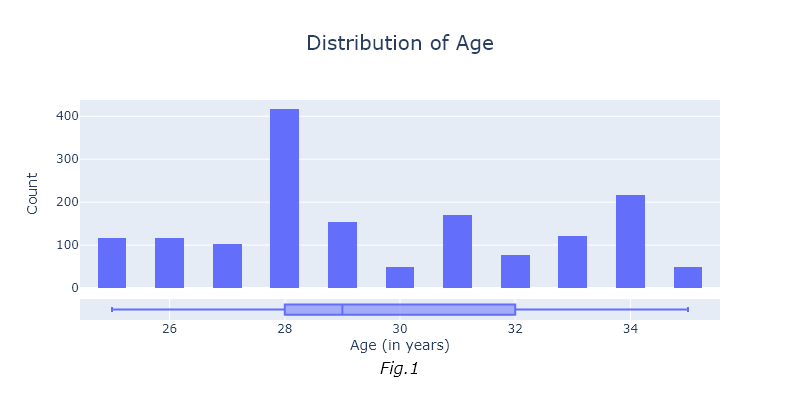


            Age
count  1589.000
mean     29.659
std       2.925
min      25.000
25%      28.000
50%      29.000
75%      32.000
max      35.000



In [17]:
hist_box_eda(df_train, "Age", "Age (in years)", "Fig.1", render_mode)

Numerical feature `Age` represents age of the Company's customers in years. It consists of 1,589 observations with an average age of approximately 29.66 years and a standard deviation of 2.93 years, indicating a relatively narrow spread around the mean. The ages range from 25 to 35 years, with the 25th percentile at 28 years, the median at 29 years, and the 75th percentile at 32 years. This distribution suggests that most ages are clustered within a narrow range, showing a slightly right-skewed pattern as the mean is slightly higher than the median.

However, closer look at the plot in *Fig.1* suggests a bimodal distribution with the top peak at 28 years and a smaller, not so obvious peak at 34 years. Limited range of values in the variable `Age` suggests that the Company is in particular interested in (or offers travel insurance only to) customers from 25 to 35 years of age. Box plot does not indicate any potential outliers.

#### Conversion rates

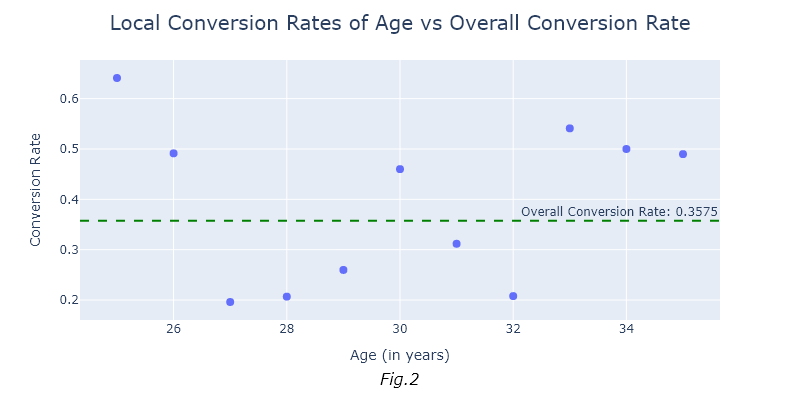

In [18]:
local_conversion_rate_scatter(
    df_train,
    "Age",
    "Age (in years)",
    "TravelInsurance",
    overall_conversion_rate,
    "Fig.2",
    render_mode,
)

The scatterplot in *Fig.2* above shows different conversion rates at each of the `Age` values. A green dashed line, indicating level of overall conversion rate, is added for comparison with local conversion rates. 

The scatterplot reveals a broad range of local conversion rates, spanning from 0.20 to 0.64. Notably, the local conversion rate at age 31 is closest to the overall conversion rate. Interestingly, the local conversion rate at the peak of the age distribution (28 years) is the second-lowest (0.21) among all age groups. In contrast, age groups at both extremes of the distribution exhibit higher local conversion rates than the overall average: 0.64 at 25 years, 0.54 at 33 years, and 0.49 at 35 years.

Given the relatively narrow range and discrete nature of the `Age` variable, it can be treated as categorical. However, the significant variability in local conversion rates across age groups suggests encoding the `Age` categories using the *OneHotEncoder*.

#### Statistical Tests

Statistical significance of variable `Age` for the outcome of target variable `TravelInsurance` is assessed in this section by performing t-test on the means of variable `Age` for those, who purchased travel insurance (`TravelInsurance` = 1) and those, who did not (`TravelInasurance` = 0).

Before performing t-test on the means, necessary assumptions will be checked. First the two distributions will be checked for normality(*Shapiro-Wilk test*). In case the distributions are not normal, presumptions of **Central Limit Theorem** will be applied, as sample sizes being tested are of large size (n > 30). Therefore, regardless of the *Shapiro-Wilk* test results, homogeneity of variance will be tested (*Levene's test*). Depending on the results of the *Levene's test*, either *Student's t-test* (if variances are similar) or *Welch's t-test* (if variances are not similar) will be conducted.

In [19]:
ttest_with_assumptions_check(df_train, "Age", "TravelInsurance")

**Normality Test for "Age" where "TravelInsurance" = 0:**  
        H₀: The distribution of "Age" for "TravelInsurance" = 0 is normal.  
        H₁: The distribution of "Age" for "TravelInsurance" = 0 is not normal.

Shapiro-Wilk test statistic: 0.9155, p-value: 2.0407e-23

**Conclusion:** `Reject` H₀. The distribution is `not normal`.

**Normality Test for "Age" where "TravelInsurance" = 1:**  
        H₀: The distribution of "Age" for "TravelInsurance" = 1 is normal.  
        H₁: The distribution of "Age" for "TravelInsurance" = 1 is not normal.

Shapiro-Wilk test statistic: 0.8996, p-value: 7.6425e-19

**Conclusion:** `Reject` H₀. The distribution is `not normal`.

<br>**Homogeneity of Variances Test for "Age":**  
    H₀: The variances of "Age" for the two groups are equal.  
    H₁: The variances of "Age" for the two groups are not equal.

Levene's test statistic: 72.0521, p-value: 4.7393e-17

**Conclusion:** `Reject` H₀. The variances are `not equal`.

<br>**T-Test for Means of "Age":**  
    H₀: The means of "Age" for the two groups are equal.  
    H₁: The means of "Age" for the two groups are not equal.

T-test statistic: -2.5787, p-value: 1.0065e-02

**Conclusion:** `Reject` H₀. There is a `significant difference` in means.

T-test results (p-value < 0.05) reveal that variable `Age` is statistically significant for the outcome of the target variable `TravelInsurance`. 

Similar sequences of hypotheses will be formulated and the hypotheses will be tested by performing statistical tests also for numerical variables `AnnualIncome` and `Family Members`.

### 3.2.4 Annual Income
#### Distribution

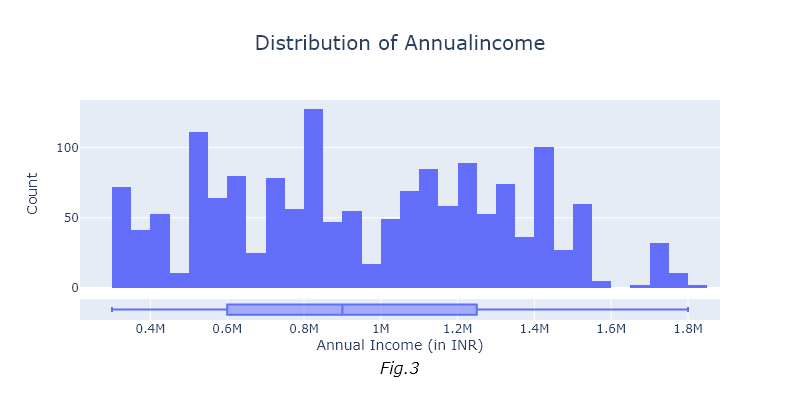


       AnnualIncome
count       1589.00
mean      930018.88
std       374983.71
min       300000.00
25%       600000.00
50%       900000.00
75%      1250000.00
max      1800000.00



In [20]:
hist_box_eda(df_train, "AnnualIncome", "Annual Income (in INR)", "Fig.3", render_mode)

The `AnnualIncome` variable repsesents annual income of the Company's customers in Indian Rupees, with values rounded to the nearest 50,000 Indian Rupees (INR).

The `AnnualIncome` variable, based on the summary statistics, shows an average income of approximately 930,019 INR with a standard deviation of 374,984 INR, indicating notable variability among individuals. The median income is 900,000 INR, slightly lower than the mean, suggesting a slight right-skew in the data. Most individuals earn between 600,000 INR (25th percentile) and 1,250,000 INR (75th percentile), as captured by the interquartile range. The minimum and maximum incomes range from 300,000 INR to 1,800,000 INR, highlighting the presence of higher-income earners in the dataset.

> Interesting fact: according to the average exchange rate of INR to EUR in 2019, 100,000 INR was equal to roughly 1,200 EUR, ending up the highest earning Company's customer from the dataset with an equivalent of around 21,600 EUR per year.

The histogram in *Fig.3* confirms this right-skewed distribution, with a concentration of values around 800,000 INR and 1,200,000 INR and fewer observations as incomes approach the higher end. The income distribution exhibits peaks at certain intervals, while incomes above 1,400,000 INR are less frequent. Overall, the data suggests that while most individuals fall within a moderate income range, there is a small group of higher-income earners driving the mean slightly above the median.

There are no outliers in `AnnualIncome` variable.

#### Conversion rates

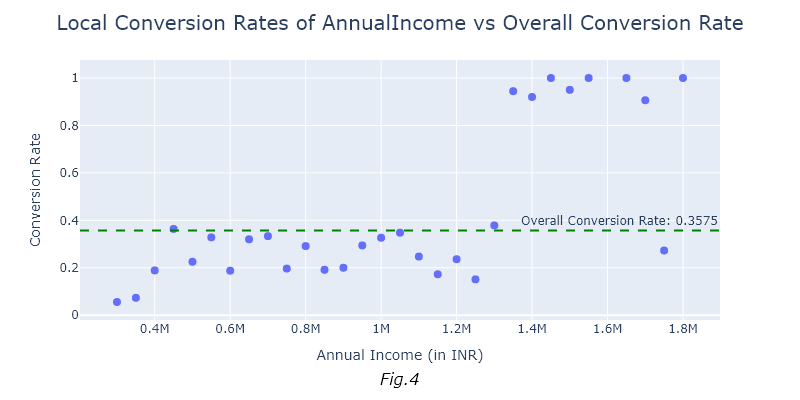

In [21]:
local_conversion_rate_scatter(
    df_train,
    "AnnualIncome",
    "Annual Income (in INR)",
    "TravelInsurance",
    overall_conversion_rate,
    "Fig.4",
    render_mode,
)

The scatterplot in *Fig.4* shows local conversion rates for different `AnnualIncome` levels compared to the overall conversion rate (0.3575, green dashed line). For incomes below 1,400,000 INR, most local conversion rates cluster around or below the overall rate, with several points dropping as low as 0.2. In contrast, for incomes above 1,400,000 INR, conversion rates are consistently higher, often approaching 1.0. This indicates that higher incomes are strongly associated with better conversion rates, while lower incomes show more variability and generally lower performance.

For modeling purposes, the `AnnualIncome` variable will be included as a numeric feature. Given its broad range and variability, *min-max scaling* will be applied to ensure model stability and prevent from dominating the model.

#### Statistical Tests

The same logic of hypotheses formulation and statistical tests as for variable `Age` in *Chapter 3.2.3* will be applied to variable `AnnualIncome` in this section.

In [22]:
ttest_with_assumptions_check(df_train, "AnnualIncome", "TravelInsurance")

**Normality Test for "AnnualIncome" where "TravelInsurance" = 0:**  
        H₀: The distribution of "AnnualIncome" for "TravelInsurance" = 0 is normal.  
        H₁: The distribution of "AnnualIncome" for "TravelInsurance" = 0 is not normal.

Shapiro-Wilk test statistic: 0.9593, p-value: 2.9553e-16

**Conclusion:** `Reject` H₀. The distribution is `not normal`.

**Normality Test for "AnnualIncome" where "TravelInsurance" = 1:**  
        H₀: The distribution of "AnnualIncome" for "TravelInsurance" = 1 is normal.  
        H₁: The distribution of "AnnualIncome" for "TravelInsurance" = 1 is not normal.

Shapiro-Wilk test statistic: 0.9285, p-value: 8.1473e-16

**Conclusion:** `Reject` H₀. The distribution is `not normal`.

<br>**Homogeneity of Variances Test for "AnnualIncome":**  
    H₀: The variances of "AnnualIncome" for the two groups are equal.  
    H₁: The variances of "AnnualIncome" for the two groups are not equal.

Levene's test statistic: 18.7705, p-value: 1.5668e-05

**Conclusion:** `Reject` H₀. The variances are `not equal`.

<br>**T-Test for Means of "AnnualIncome":**  
    H₀: The means of "AnnualIncome" for the two groups are equal.  
    H₁: The means of "AnnualIncome" for the two groups are not equal.

T-test statistic: -16.3911, p-value: 6.7927e-54

**Conclusion:** `Reject` H₀. There is a `significant difference` in means.

T-test results (p-value < 0.05) reveal that variable `AnnualIncome` is statistically significant for the outcome of the target variable `TravelInsurance`.

### 3.2.5 Family Members

#### Distribution

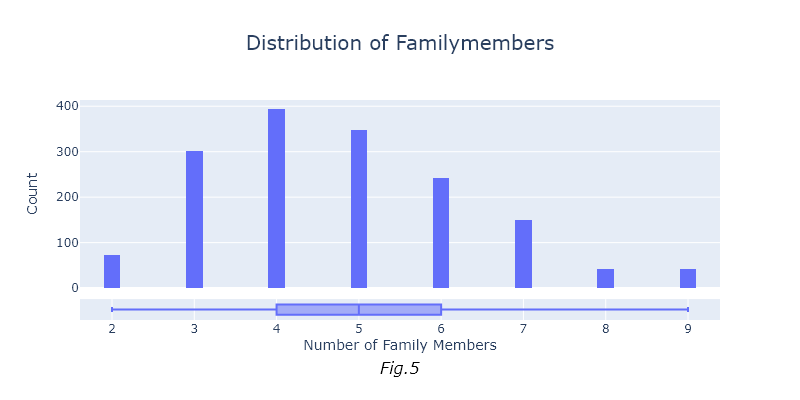


       FamilyMembers
count       1589.000
mean           4.761
std            1.596
min            2.000
25%            4.000
50%            5.000
75%            6.000
max            9.000



In [23]:
hist_box_eda(
    df_train, "FamilyMembers", "Number of Family Members", "Fig.5", render_mode
)

Distribution of `FamilyMembers` is shown in *Fig.5*. The mean family size is approximately 4.761, with a median of 5, indicating right-skewness of the distribution. The standard deviation of 1.596 suggests moderate variability in family size. The first and third quartiles, at 4 and 6 respectively, show that 50% of families have between 4 and 6 members. The distribution is concentrated around 4 and 5 members, with fewer families at the extremes of 2 or 9 members.

> Interesting fact: According to 2021 census a household (family) in India averaged 4.4 persons.

No outliers have been detected.

#### Conversion Rates

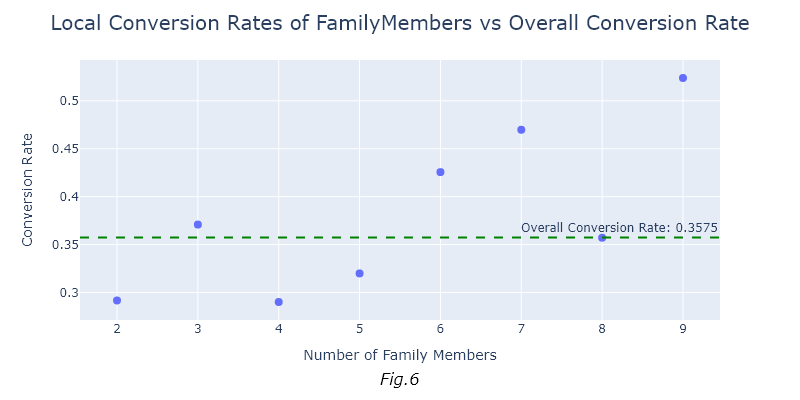

In [24]:
local_conversion_rate_scatter(
    df_train,
    "FamilyMembers",
    "Number of Family Members",
    "TravelInsurance",
    overall_conversion_rate,
    "Fig.6",
    render_mode,
)

In *Fig.6* local conversion rates for different family sizes (2 to 9) against the overall conversion rate of 0.3575 (green dashed line) are displayed. Families with 6 or more members show conversion rates above the overall average, with 9 family members reaching the highest rate of around 0.52. In contrast, smaller families, particularly those with 2, 4, and 5 members, exhibit below-average conversion rates (approximately 0.29). The trend suggests that larger families are more likely to convert, while smaller families show fluctuating and lower conversion rates.

The variable `FamilyMembers` is categorical because it represents discrete family sizes, and treating it as a numeric variable may introduce an incorrect ordinal assumption. The relationship with conversion rates is clearly non-linear, as rates fluctuate and do not follow a strict increasing or decreasing trend. *OneHot Encoding* preserves this categorical nature, allowing the model to treat each family size independently and assign unique coefficients to capture their distinct contributions to the target variable. This approach avoids misleading relationships, improves interpretability, and ensures the model accurately captures variations across family sizes.

#### Statistical Tests

In this section hypotheses are formulated and statistical tests are conducted for `FamilyMembers` variable in the similar manner as for `Age` and `AnnualIncome` in *Chapters 3.2.3* and *3.2.4* respectively.

In [25]:
ttest_with_assumptions_check(df_train, "FamilyMembers", "TravelInsurance")

**Normality Test for "FamilyMembers" where "TravelInsurance" = 0:**  
        H₀: The distribution of "FamilyMembers" for "TravelInsurance" = 0 is normal.  
        H₁: The distribution of "FamilyMembers" for "TravelInsurance" = 0 is not normal.

Shapiro-Wilk test statistic: 0.9370, p-value: 2.2955e-20

**Conclusion:** `Reject` H₀. The distribution is `not normal`.

**Normality Test for "FamilyMembers" where "TravelInsurance" = 1:**  
        H₀: The distribution of "FamilyMembers" for "TravelInsurance" = 1 is normal.  
        H₁: The distribution of "FamilyMembers" for "TravelInsurance" = 1 is not normal.

Shapiro-Wilk test statistic: 0.9423, p-value: 4.7090e-14

**Conclusion:** `Reject` H₀. The distribution is `not normal`.

<br>**Homogeneity of Variances Test for "FamilyMembers":**  
    H₀: The variances of "FamilyMembers" for the two groups are equal.  
    H₁: The variances of "FamilyMembers" for the two groups are not equal.

Levene's test statistic: 6.3596, p-value: 1.1772e-02

**Conclusion:** `Reject` H₀. The variances are `not equal`.

<br>**T-Test for Means of "FamilyMembers":**  
    H₀: The means of "FamilyMembers" for the two groups are equal.  
    H₁: The means of "FamilyMembers" for the two groups are not equal.

T-test statistic: -3.5361, p-value: 4.2328e-04

**Conclusion:** `Reject` H₀. There is a `significant difference` in means.

T-test results (p-value < 0.05) show that variable `FamilyMembers` is also statistically significant for the outcome of the target variable `TravelInsurance`.

### 3.2.6 Binary Features

#### Proportions and Conversion Rates
Binary features in this dataset are proportions by nature, represented mostly by values "Yes" or "No", except `ChronicDiseases` variable, which is encoded with 0 and 1, corresponding to absence of chronic illnesses (value 0) or presence of such (value 1), and `Employment Type`, which is encoded with values "Government Sector" and "Private Sector/Self Employed".

Only for EDA purposes - better readability and graphic presentation - `Employment Type` will be renamed to `Government Sector` and values will be encoded accordingly. For the same purposes values of `ChronicDiseases` will be encoded to "Yes" and "No" as well.

In [26]:
df_train.rename(columns={"Employment Type": "Government Sector"}, inplace=True)

df_train["Government Sector"] = df_train["Government Sector"].replace(
    {"Government Sector": "Yes", "Private Sector/Self Employed": "No"}
)

df_train["ChronicDiseases"] = df_train["ChronicDiseases"].replace({1: "Yes", 0: "No"})

binary_features = [
    "Government Sector",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

In [27]:
def conversion_rate_confidence_interval(conversion_rate, n):
    margin_of_error = 1.96 * np.sqrt(conversion_rate * (1 - conversion_rate) / n)
    return conversion_rate - margin_of_error, conversion_rate + margin_of_error

In [28]:
summary_data = []

for feature in binary_features:
    feature_df = (
        df_train.groupby(feature)["TravelInsurance"]
        .agg(count="count", mean="mean")
        .reset_index()
    )

    feature_df["Feature"] = feature
    feature_df["Percentage"] = 100 * feature_df["count"] / feature_df["count"].sum()

    lower_bound, upper_bound = zip(
        *[
            conversion_rate_confidence_interval(row["mean"], row["count"])
            for _, row in feature_df.iterrows()
        ]
    )

    feature_df["Lower Bound"] = lower_bound
    feature_df["Upper Bound"] = upper_bound

    feature_df.rename(columns={feature: "Value"}, inplace=True)

    summary_data.append(feature_df)

summary_df = pd.concat(summary_data, ignore_index=True)
summary_df = summary_df[
    ["Feature", "Value", "count", "Percentage", "mean", "Lower Bound", "Upper Bound"]
]

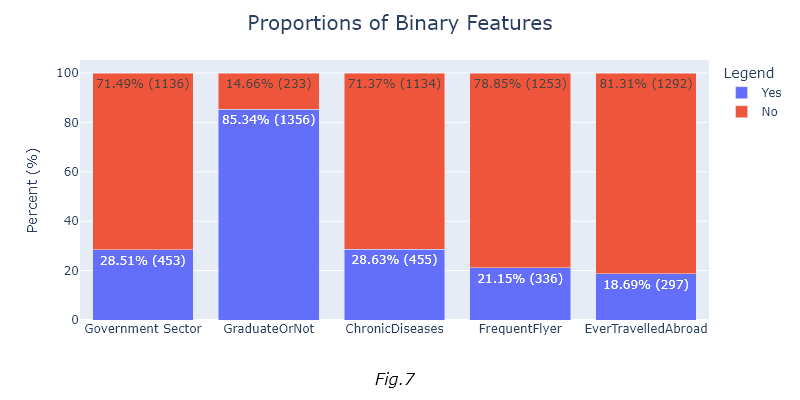

,Feature,Value,count,Percentage,mean,Lower Bound,Upper Bound
0,Government Sector,No,1136,71.491504,0.404049,0.375514,0.432585
1,Government Sector,Yes,453,28.508496,0.240618,0.201254,0.279982
2,GraduateOrNot,No,233,14.663310,0.351931,0.290609,0.413254
3,GraduateOrNot,Yes,1356,85.336690,0.358407,0.332883,0.383931
4,ChronicDiseases,No,1134,71.365639,0.350970,0.323191,0.378749
5,ChronicDiseases,Yes,455,28.634361,0.373626,0.329175,0.418078
6,FrequentFlyer,No,1253,78.854626,0.300878,0.275483,0.326273
7,FrequentFlyer,Yes,336,21.145374,0.568452,0.515492,0.621412
8,EverTravelledAbroad,No,1292,81.308999,0.260836,0.236893,0.284779
9,EverTravelledAbroad,Yes,297,18.691001,0.777778,0.730495,0.825060


In [29]:
fig7 = px.bar(
    summary_df,
    x="Feature",
    y="Percentage",
    color="Value",
    text=summary_df.apply(
        lambda row: f'{row["Percentage"]:.2f}% ({row["count"]})', axis=1
    ),
    labels={"count": "Count", "Feature": "Feature"},
    barmode="stack",
    category_orders={"Feature": binary_features, "Value": ["Yes", "No"]},
)

fig7.update_traces(textposition="inside")
fig_update(
    fig7,
    "Proportions of Binary Features",
    "<i>Fig.7</i>",
    "",
    "Percent (%)",
    "Legend",
    800,
    400,
)

fig_px_render(fig7, render_mode, "Fig7")
summary_df

Figure *Fig.7* shows the proportions of the binary features, with categories "Yes" and "No" displayed as stacked bars. Features like `GraduateOrNot` and `EverTravelledAbroad` are highly imbalanced, with over 85% and 81% of observations in the "Yes" and "No" categories, respectively.

Notably, as also shown in *Fig.8* below, the local conversion rates (mean) vary significantly within these categories. For instance, `EverTravelledAbroad` (Yes) has the highest local conversion rate of 0.7778, while its "No" counterpart has a much lower rate of 0.2608. Similarly, `FrequentFlyer` (Yes) shows a conversion rate of 0.5685, compared to 0.3009 for "No." These patterns suggest that certain binary features, particularly `EverTravelledAbroad` and `FrequentFlyer`, have strong predictive potential for the target and highlight the importance of accounting for such imbalances in modeling.

On the other hand, features `GraduateOrNot` and `ChronicDiseases`, despite being imbalanced as well, exhibit no significant difference in local conversion rates within categories "Yes" and "No. Local conversion rates of both of categories of both of the features show values approximately equal to the overall conversion rate with overlapping confidence intervals.

For modeling purposes all binary features will be encoded with *OneHot Encoder*.

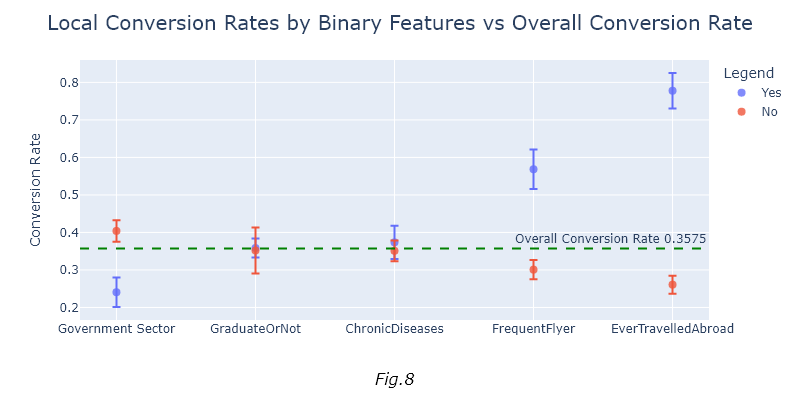

In [30]:
fig8 = px.scatter(
    summary_df,
    x="Feature",
    y="mean",
    color="Value",
    error_y=summary_df["Upper Bound"] - summary_df["mean"],
    error_y_minus=summary_df["mean"] - summary_df["Lower Bound"],
    labels={"mean": "Local Conversion Rate", "Feature": "Feature"},
    category_orders={"Feature": binary_features, "Value": ["Yes", "No"]},
)

fig8.update_traces(marker=dict(size=8, opacity=0.8), showlegend=True)

fig_update(
    fig8,
    "Local Conversion Rates by Binary Features vs Overall Conversion Rate",
    "<i>Fig.8</i>",
    "",
    "Conversion Rate",
    "Legend",
    800,
    400,
)

fig8.add_hline(
    y=overall_conversion_rate,
    line=dict(color="green", dash="dash"),
    annotation_text=f"Overall Conversion Rate {overall_conversion_rate:.4f}",
    annotation_position="top right",
)

fig_px_render(fig8, render_mode, "Fig8")

#### Statistical Tests

In [31]:
for feature in binary_features:
    ztest_proportions_of_1(df_train, feature, "TravelInsurance")

**Proportion Test for "TravelInsurance" = 1 proportions in "Government Sector":**<br>
                H₀: The proportion of 1 in "TravelInsurance" is equal for "Government Sector" = "Yes" and "Government Sector" = "No".<br>
                H₁: The proportions are different.

Z-test statistic: -6.1369, p-value: 8.4154e-10

**Conclusion:** `Reject` H₀. There is a `significant difference` in the proportions between the two groups.<br><br>

**Proportion Test for "TravelInsurance" = 1 proportions in "GraduateOrNot":**<br>
                H₀: The proportion of 1 in "TravelInsurance" is equal for "GraduateOrNot" = "Yes" and "GraduateOrNot" = "No".<br>
                H₁: The proportions are different.

Z-test statistic: 0.1905, p-value: 8.4889e-01

**Conclusion:** Fail to reject H₀. There is no significant difference in the proportions between the two groups.<br><br>

**Proportion Test for "TravelInsurance" = 1 proportions in "ChronicDiseases":**<br>
                H₀: The proportion of 1 in "TravelInsurance" is equal for "ChronicDiseases" = "Yes" and "ChronicDiseases" = "No".<br>
                H₁: The proportions are different.

Z-test statistic: 0.8519, p-value: 3.9428e-01

**Conclusion:** Fail to reject H₀. There is no significant difference in the proportions between the two groups.<br><br>

**Proportion Test for "TravelInsurance" = 1 proportions in "FrequentFlyer":**<br>
                H₀: The proportion of 1 in "TravelInsurance" is equal for "FrequentFlyer" = "Yes" and "FrequentFlyer" = "No".<br>
                H₁: The proportions are different.

Z-test statistic: 9.0879, p-value: 1.0095e-19

**Conclusion:** `Reject` H₀. There is a `significant difference` in the proportions between the two groups.<br><br>

**Proportion Test for "TravelInsurance" = 1 proportions in "EverTravelledAbroad":**<br>
                H₀: The proportion of 1 in "TravelInsurance" is equal for "EverTravelledAbroad" = "Yes" and "EverTravelledAbroad" = "No".<br>
                H₁: The proportions are different.

Z-test statistic: 16.7620, p-value: 4.6271e-63

**Conclusion:** `Reject` H₀. There is a `significant difference` in the proportions between the two groups.<br><br>

Conducted Z-test for proportions reveal that there is no significant difference in local conversion rates between the categories "Yes" and "No" of both `GraduateOrNot` and `ChronicDiseases` features. For the remaining features the differences are statistically significant.

### 3.2.7 Relationships of Variables (Phik Correlation)

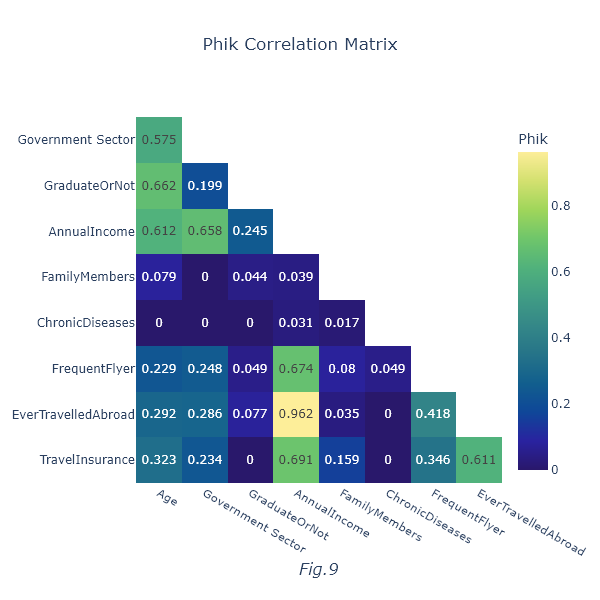

In [32]:
phik_corr_matrix = df_train.phik_matrix(interval_cols=["AnnualIncome"]).round(3)

mask = np.triu(np.ones_like(phik_corr_matrix, dtype=bool))

phik_corr_matrix[mask] = np.nan

phik_corr_matrix = phik_corr_matrix.iloc[1:, :-1]

fig9 = px.imshow(
    phik_corr_matrix,
    labels=dict(color="Phik Correlation"),
    x=phik_corr_matrix.columns,
    y=phik_corr_matrix.index,
    color_continuous_scale="haline",
    title="Phik Correlation Matrix",
    text_auto=True,
)

fig9.update_layout(
    width=600,
    height=600,
    plot_bgcolor="rgba(0,0,0,0)",
    coloraxis_colorbar=dict(title="Phik", len=0.9),
    title_x=0.5,
    margin=dict(b=100),
    annotations=[
        dict(
            x=0.5,
            y=-0.2,
            text="<i>Fig.9</i>",
            showarrow=False,
            font=dict(size=16),
            xref="paper",
            yref="paper",
        )
    ],
)


fig_px_render(fig9, render_mode, "Fig9")

The Phik correlation matrix in *Fig.9* shows similar strength of feature relationships to those identified by conducting statistical tests in previous sections. There are strong relationships, particularly between `EverTravelledAbroad` and `TravelInsurance` (0.611), indicating that those who have traveled abroad are much more likely to have travel insurance. A very strong correlation also exists between `AnnualIncome` and `EverTravelledAbroad` (0.962), highlighting that high earners often have travel experience abroad. Furthermore, `Government Sector` (`Employment Type`) and `AnnualIncome` (0.658) suggest that level ofincome strongly relates to whether a customer is employed privately of in the government sector.

On the weaker side, `FamilyMembers` and `TravelInsurance` (0.159) show a low correlation, suggesting family size does not significantly affect travel insurance ownership. Additionally, `ChronicDiseases` (0.0) has no correlation with `TravelInsurance`, indicating health conditions don’t impact travel insurance decisions. The `Age` correlation with `TravelInsurance` (0.323) is moderate, showing that age has some influence on the likelihood of having travel insurance. This matrix underscores the influence of travel-related behaviors on insurance ownership, while family size and health conditions are less impactful.

### 3.2.8 EDA Summary

#### Feature Importance
Based on the findings from the EDA, the key numerical features for describing a potential buyer of the travel insurance package are `Age`, `AnnualIncome`, and `FamilyMembers`. Among the binary features, `Employment Type` (referred to as `Government Sector` in the EDA), `FrequentFlyer`, and `EverTravelledAbroad`also play significant roles in characterizing the target buyers.

Conversely, features like GraduateOrNot (education level) and ChronicDiseases (health conditions) do not appear to contribute substantially to identifying potential buyers.

Nevertheless, during model construction and training, feature importance may shift, and certain variables that seemed less relevant during EDA could prove to be influential in predicting outcomes. Therefore all of the features will be considered for modeling process.

#### A Perfect Customer
Considering the information retrieved from the data throughout the EDA, the perfect customer of the Travel & Tours Company may be described as a representative of **private sector** (or **self-employed**) of 33-35 years of **age** with more than 5 persons in the **family** and **annual income** of more than 1.3 million INR. The perfect customer also likes to **travel abroad** and therefore has a **frequent flyer** status.

# 4. Pipelines and Models

## 4.1 Pipelines
As described in throughout *Chapter 3.2*, some of the features will be encoded, while some will be scaled. All encoding and transformations will be implemented using *pipelines* for transparency and reproducibility of the workflow. Below is list of all features of dataset with actions planned for them during the preprocessing for modeling:
- `Age`, `FamilyMembers`: due to discrete nature and limited range these features will be treated as categorical and will be encoded using *OneHotEncoder*;
- `AnnualIncome`: given broad range and variability of the feature, min-max scaling will be applied;
- `Employment Type`: binary values "Government Sector" and "Private Sector/Self-Employed" will be encoded using *OneHotEncoder*;
- `GraduateOrNot`, `FrequentFlyer` and `EverTravelledAbroad`: these binary features have values "Yes" and "No", which will be encoded using *OneHotEncoder* as well, however a *drop='first'* argument will be used to avoid redundancies.

All the actions described above will be included into a *preprocessor*, which later will become a part of a *pipeline*.

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("minmax_scaler", MinMaxScaler(), ["AnnualIncome"]),
        (
            "onehot_age_fm_et",
            OneHotEncoder(),
            ["Age", "FamilyMembers", "Employment Type"],
        ),
        (
            "onehot_dropfirst",
            OneHotEncoder(drop="first"),
            ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"],
        ),
    ],
    remainder="passthrough",
)

## 4.2 First Pipeline - Dummy Model
### 4.2.1 Pipeline
For indication of how *pipeline* works and as a baseline for other models a *Dummy Model pipeline* is constructed. It consists of the *preprocessor, constructed in *Chapter 4.1* and a *DummyClassifier* with stratified strategy. The stratified strategy in a *DummyClassifier* generates predictions by respecting the distribution of classes in the training data.

In [34]:
dummy_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            DummyClassifier(strategy="stratified", random_state=random_seed),
        ),
    ]
)

In [35]:
dummy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax_scaler',
                                                  MinMaxScaler(),
                                                  ['AnnualIncome']),
                                                 ('onehot_age_fm_et',
                                                  OneHotEncoder(),
                                                  ['Age', 'FamilyMembers',
                                                   'Employment Type']),
                                                 ('onehot_dropfirst',
                                                  OneHotEncoder(drop='first'),
                                                  ['GraduateOrNot',
                                                   'FrequentFlyer',
                                                   'EverTravelledAbroad'])])),
                ('classifier',
                 DummyClassifier(random_state=2024, strategy='stratified'))])

### 4.2.2 Performance

Full Classification Report:
              precision    recall  f1-score   support

Majority (0)       0.63      0.63      0.63      1021
Minority (1)       0.34      0.35      0.34       568

    accuracy                           0.53      1589
   macro avg       0.49      0.49      0.49      1589
weighted avg       0.53      0.53      0.53      1589



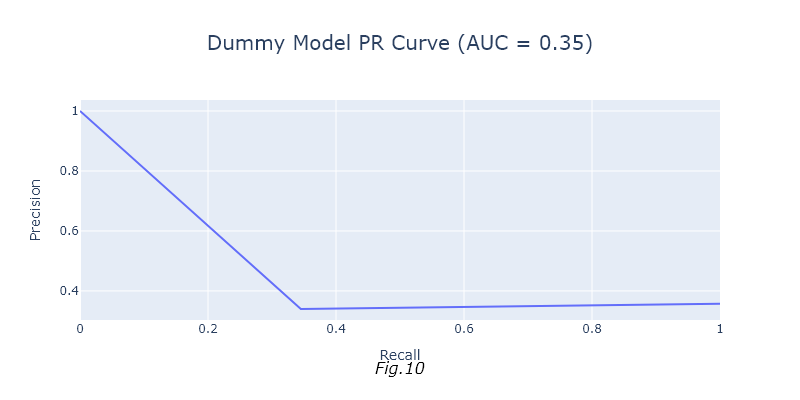

In [36]:
y_pred = dummy_pipeline.predict(X_train)
y_pred_proba = dummy_pipeline.predict_proba(X_train)[:, 1]

print("Full Classification Report:")
print(
    classification_report(
        y_train_array, y_pred, target_names=["Majority (0)", "Minority (1)"]
    )
)

precision, recall, thresholds = precision_recall_curve(y_train_array, y_pred_proba)
pr_auc = average_precision_score(y_train_array, y_pred_proba)

pr_data = pd.DataFrame({"Recall": recall, "Precision": precision})

fig10 = px.line(
    pr_data,
    x="Recall",
    y="Precision",
    title=f"Precision-Recall Curve (AUC = {pr_auc:.2f})",
    labels={"Recall": "Recall", "Precision": "Precision"},
)

fig_update(
    fig10,
    "Dummy Model PR Curve (AUC = 0.35)",
    "<i>Fig.10</i>",
    "Recall",
    "Precision",
    "",
    800,
    400,
)

fig_px_render(fig10, render_mode, "Fig10")

Fitting the *Dummy Model pipeline* and predicting the *training* data with it show *Accuracy* of 0.53. This means that random stratified prediction gives correct outcomes in slightly more than half predictions.

### 4.2.3 PR AUC vs Accuracy as Evaluation Metric
In cases where outcomes are rather balanced, *Accuracy* would be used to evaluate performance of models. However in the cases of imbalanced datasets, *Accuracy* may be misleading as it may be achieved by correctly predicting majority outcome and somewhat ignoring the minority. In this dataset, where the positive outcome is of primary interest, **Precision-Recall AUC** is the metric to consider (for graphic representation of PR Curve and PR AUC, please refer to *Fig.10* above).

**PR AUC** focuses on **precision** and **recall**, which are relevant for evaluating the performance of the positive class. It evaluates how well the model identifies and prioritizes positive samples, even in the presence of many negatives. *Dummy Model pipeline's* **PR AUC** is quite low at 0.35, which can be explained by random prediction.

## 4.3 Model Selection and Next Steps

In [37]:
models = [
    ("Logistic Regression", LogisticRegression(random_state=random_seed)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=random_seed)),
    ("Random Forest", RandomForestClassifier(random_state=random_seed)),
    ("Linear SVC", SVC(kernel="linear", probability=True, random_state=random_seed)),
    ("Radial SVC", SVC(kernel="rbf", probability=True, random_state=random_seed)),
    ("Naive Bayes", MultinomialNB()),
]

The following classifier models have been selected for consideration in this project:
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Random Forest
- Linear SVC
- Radial SVC
- Naive Bayes

The following steps were be performed on *train* data with the selected models:
- each model will be added to a pipeline and fit with preprocessed data
- initial *Accuracy* and *PR AUC* will be derived from prediction with default model settings
- each model will be *cross-validated*
- hyperparameters for each model will be tuned with *GridSearchCV*
- metrics before *cross-validation* and after tuning will be analysed
- 3 most promising models will be selected for predictions from unseen *test* data

After completion of all the steps on *train* data, the final steps were performed on *test*:
- predictions and analysis of the 3 ultimately selected models
- construction of the *voting ensemble*
- predictions and analysis of the *voting ensemble*
- comparison of results of the 3 individual models and the ensemble.

Actions, observations and findings are described in the following chapters.

## 4.4 Model Performance on Test Data

### 4.4.1 Initial Scores with Default Settings

In [38]:
results = []

for model_name, model in models:
    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    pipeline.fit(X_train, y_train_array)
    y_pred = pipeline.predict(X_train)
    y_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    accuracy = accuracy_score(y_train_array, y_pred)
    pr_auc = average_precision_score(y_train_array, y_pred_proba)

    results.append(
        {"Model": model_name, "Initial Accuracy": accuracy, "Initial PR AUC": pr_auc}
    )

model_results = pd.DataFrame(results)
model_results

,Model,Initial Accuracy,Initial PR AUC
0,Logistic Regression,0.791693,0.745982
1,K-Nearest Neighbors,0.833858,0.817003
2,Decision Tree,0.916929,0.963144
3,Random Forest,0.916929,0.965318
4,Linear SVC,0.746381,0.683340
5,Radial SVC,0.828194,0.817728
6,Naive Bayes,0.763373,0.704497


All models were fit and tried out on the *train* data with default settings. *Decision Tree* and *Random Forest* standout from the rest with very high *Accuracy* and *PR AUC*, one of the main possible reasons being possible overfitting on the *train* data. This issue can be addressed during *cross-validation* and *hyperparameter tuning*, when model performance on unseen data is being simulated.

The rest of the models generalize quite well.

### 4.4.2 Cross-validation

In [39]:
cv_data = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

for model_name, model in models:
    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    accuracy_scores = cross_val_score(
        pipeline, X_train, y_train_array, cv=kf, scoring="accuracy"
    )

    pr_auc_scores = cross_val_score(
        pipeline, X_train, y_train_array, cv=kf, scoring="average_precision"
    )

    accuracy_mean = accuracy_scores.mean()
    accuracy_std = accuracy_scores.std()
    pr_auc_mean = pr_auc_scores.mean()
    pr_auc_std = pr_auc_scores.std()

    model_results.loc[
        model_results["Model"] == model_name,
        [
            "Accuracy Mean (CV)",
            "Accuracy STD (CV)",
            "PR AUC Mean (CV)",
            "PR AUC STD (CV)",
        ],
    ] = [accuracy_mean, accuracy_std, pr_auc_mean, pr_auc_std]

    cv_data.append(
        {"Model": model_name, "Accuracy": accuracy_scores, "PR AUC": pr_auc_scores}
    )

cv_data_df = pd.DataFrame(cv_data)

model_results

,Model,Initial Accuracy,Initial PR AUC,Accuracy Mean (CV),Accuracy STD (CV),PR AUC Mean (CV),PR AUC STD (CV)
0,Logistic Regression,0.791693,0.745982,0.784150,0.008598,0.726208,0.031159
1,K-Nearest Neighbors,0.833858,0.817003,0.777862,0.018668,0.674196,0.034800
2,Decision Tree,0.916929,0.963144,0.758979,0.013974,0.584519,0.019228
3,Random Forest,0.916929,0.965318,0.777856,0.013291,0.747495,0.028705
4,Linear SVC,0.746381,0.683340,0.741361,0.012534,0.691311,0.020503
5,Radial SVC,0.828194,0.817728,0.806186,0.022061,0.759160,0.038515
6,Naive Bayes,0.763373,0.704497,0.755207,0.015367,0.692297,0.042762


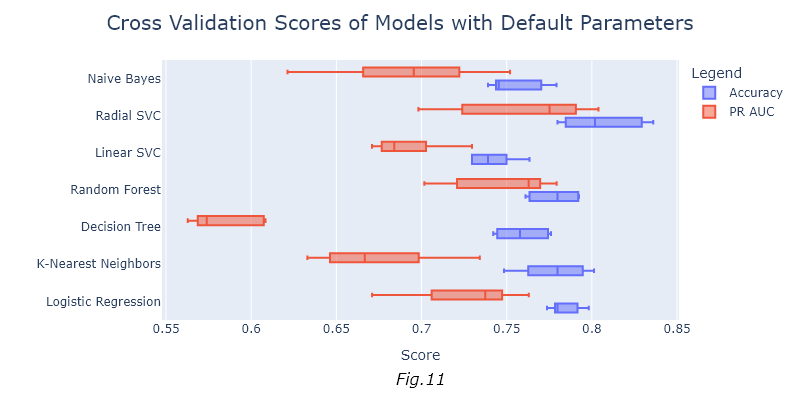

In [40]:
accuracy_expanded = cv_data_df.explode("Accuracy").rename(columns={"Accuracy": "Score"})
accuracy_expanded["Metric"] = "Accuracy"

pr_auc_expanded = cv_data_df.explode("PR AUC").rename(columns={"PR AUC": "Score"})
pr_auc_expanded["Metric"] = "PR AUC"

combined_df = pd.concat(
    [
        accuracy_expanded[["Model", "Metric", "Score"]],
        pr_auc_expanded[["Model", "Metric", "Score"]],
    ]
)

fig11 = px.box(
    combined_df,
    x="Score",
    y="Model",
    color="Metric",
    orientation="h",
    labels={"Score": "Score", "Model": "Model"},
)

fig_update(
    fig11,
    "Cross Validation Scores of Models with Default Parameters",
    "<i>Fig.11</i>",
    "Score",
    "",
    "Legend",
    800,
    400,
)

fig_px_render(fig11, render_mode, "Fig11")

*Cross-validation*, performed with 5 stratified splits, shows that while *Accuracy* does not drop significantly, changes of *PR AUC* are quite noticable. This underscores the importance of *PR AUC* as the key metric for model performance evaluation for imbalanced datasets.

Biggest drops of *PR AUC* between initial scores and cross-validation means can be observed for *Decision Tree* and *Random Forest* models, which were seemingly overfit on *train* data (from initial 0.963 and 0.965 to 0.585 and 0.747 respectively) and/or their default settings do not generalize well. Improvement in model performance will be achieved through *hyperparameter tuning* in the next chapter.

Quite consistent stability of all models on simulated unseen data, indicated by standard deviation from the *cross-validation* process, is also worth to notice.

### 4.4.3 Hyperparameter Tuning
The hyperparameters will be tuned semi-manually with *GridSearchCV*, applying the same cross-validation parameters as in *Chapter 4.4.2* for comparability.

In [41]:
models_default_tuned = model_results.copy()

models_default_tuned = models_default_tuned.drop(
    columns=["Initial Accuracy", "Accuracy Mean (CV)", "Accuracy STD (CV)"]
)

models_default_tuned = models_default_tuned.rename(
    columns={"PR AUC Mean (CV)": "Default CV Mean", "PR AUC STD (CV)": "Default CV STD"}
)

tuned_models_dict = {}

#### Logistic Regression

In [42]:
lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=random_seed)),
    ]
)

c_values = np.arange(0.01, 1, 0.01)

param_grid = {
    "classifier__C": c_values,
    "classifier__penalty": ["l1", "l2", "none"],
    "classifier__solver": ["liblinear", "lbfgs"],
    "classifier__max_iter": [100, 200],
    "classifier__class_weight": [None, "balanced"],
}

tuned_models_dict, models_default_tuned = best_tuned_model(
    lr_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "Logistic Regression",
    tuned_models_dict,
)

Fitting 5 folds for each of 2376 candidates, totalling 11880 fits
Best hyperparameters: {'classifier__C': np.float64(0.91), 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best score: 0.726779
Best score STD: 0.031806


The best hyperparameters suggest that the Logistic Regression model benefits from slightly stronger regularization (C = 0.91), which could help avoid overfitting. The choice of solver ('liblinear') suggests that it is better suited to the dataset compared to the default 'lbfgs' solver.

#### K-Nearest Neighbors

In [43]:
knn_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()),
    ]
)

n_neighbors_values = np.arange(1, 15, 1)

param_grid = {
    "classifier__n_neighbors": n_neighbors_values,
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan", "minkowski"],
    "classifier__p": [1, 2],
    "classifier__algorithm": ["auto", "brute"],
}

tuned_models_dict, models_default_tuned = best_tuned_model(
    knn_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "K-Nearest Neighbors",
    tuned_models_dict,
)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Best hyperparameters: {'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': np.int64(14), 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best score: 0.717106
Best score STD: 0.04015


The best hyperparameters suggest that the kNN model performs better with a higher number of neighbors (14 vs 5), which helps the model generalize better by smoothing out the decision boundaries and reducing the influence of noisy data. The Manhattan distance (p=1) is chosen over Euclidean distance (p=2), potentially to improve robustness, especially in cases with noisy or sparse data.

#### Decision Tree

In [44]:
dtree_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=random_seed)),
    ]
)

param_grid = {
    "classifier__max_depth": [
        None,
        10,
        20,
        30,
    ],
    "classifier__min_samples_split": [20, 30, 40],
    "classifier__min_samples_leaf": [
        2,
        3,
        4,
    ],
    "classifier__max_features": [
        None,
        "auto",
        "sqrt",
        "log2",
    ],
    "classifier__criterion": [
        "gini",
        "entropy",
    ],
    "classifier__splitter": ["best", "random"],
    "classifier__max_leaf_nodes": [
        None,
        10,
        20,
        30,
    ],
    "classifier__class_weight": [None, "balanced"],
}

tuned_models_dict, models_default_tuned = best_tuned_model(
    dtree_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "Decision Tree",
    tuned_models_dict,
)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits
Best hyperparameters: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 30, 'classifier__splitter': 'best'}
Best score: 0.758354
Best score STD: 0.025989


The best hyperparameters for the Decision Tree show a focus on addressing class imbalance with (class_weight='balanced') and improving generalization to prevent overfitting (min_samples_split=30 and min_samples_leaf=3). The use of criterion='entropy' suggests that splits based on information gain work better for this dataset than the default Gini index. 

#### Random Forest

In [45]:
rf_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=random_seed)),
    ]
)

param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [
        20,
        25,
        30,
    ],
    "classifier__min_samples_leaf": [
        1,
        2,
        4,
    ],
    "classifier__max_features": [
        "auto",
        "sqrt",
    ],
    "classifier__criterion": [
        "gini",
        "entropy",
    ],
    "classifier__bootstrap": [True],
    "classifier__class_weight": [None, "balanced"],
}
tuned_models_dict, models_default_tuned = best_tuned_model(
    rf_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "Random Forest",
    tuned_models_dict,
)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best hyperparameters: {'classifier__bootstrap': True, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 25, 'classifier__n_estimators': 200}
Best score: 0.77856
Best score STD: 0.029002


The best hyperparameters for the Random Forest focus on balancing complexity and generalization by limiting tree depth (max_depth=10), requiring larger node splits (min_samples_split=25), and increasing the number of trees (n_estimators=200). These adjustments reduce overfitting and improve model robustness while retaining the default settings for sampling, impurity measurement, and feature selection, which perform well on this dataset.

#### Linear SVC

In [46]:
svc_linear_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            SVC(kernel="linear", probability=True, random_state=random_seed),
        ),
    ]
)

param_grid = {
    "classifier__C": [100],
    "classifier__kernel": ["linear"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__tol": [1e-4, 1e-3, 1e-2],
}

tuned_models_dict, models_default_tuned = best_tuned_model(
    svc_linear_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "Linear SVC",
    tuned_models_dict,
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters: {'classifier__C': 100, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear', 'classifier__tol': 0.0001}
Best score: 0.712756
Best score STD: 0.028367


The best hyperparameters for Linear SVC use a high C value for tighter fitting to the training data (C=100), and addresses class imbalance (class_weight='balanced'). The linear kernel indicates the data is well-separated without requiring non-linear transformations, and the small tolerance ensures precise convergence. This configuration is tailored for imbalanced datasets where correctly identifying the minority class is critical, while still maintaining a focus on precision and generalization.

It is important to note that Linear SVC is very computationally costly compared to how much the model improves with additional calculations. C value selected (C=100) in this setup yields best score of 0.7128 and was computed in roughly 6 minutes on a laptop with 12th Gen Intel processor with 10 cores. Setting C to a higher value (C=10000) yields best score of 0.7136 in approximately 2 hours. In order to save time in case the notebook has to be restarted, the less computationally costly setting is selected.

#### Radial SVC

In [47]:
svc_radial_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", SVC(kernel="rbf", probability=True, random_state=random_seed)),
    ]
)

param_grid = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__gamma": [0.0001, 0.001, 0.01, 0.1, 1],
    "classifier__kernel": ["rbf"],
    "classifier__shrinking": [True],
    "classifier__tol": [1e-3],
}
tuned_models_dict, models_default_tuned = best_tuned_model(
    svc_radial_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "Radial SVC",
    tuned_models_dict,
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'classifier__shrinking': True, 'classifier__tol': 0.001}
Best score: 0.76091
Best score STD: 0.040111


The best hyperparameters for Radial SVC prioritize flexibility and smooth generalization with a moderately high C (C=10) and gamma (gamma=0.1). The RBF kernel effectively handles non-linear class separations, while shrinking enhances computational efficiency. This configuration balances capturing complex patterns in the data and minimizing overfitting

#### Naive Bayes (Multinomial)

In [48]:
nb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", MultinomialNB()),
    ]
)

alpha_values = np.arange(0.01, 0.5, 0.01)

param_grid = {
    "classifier__alpha": alpha_values,
    "classifier__fit_prior": [
        True,
        False,
    ],
    "classifier__class_prior": [None],
}

tuned_models_dict, models_default_tuned = best_tuned_model(
    nb_pipeline,
    param_grid,
    kf,
    X_train,
    y_train_array,
    models_default_tuned,
    "Naive Bayes",
    tuned_models_dict,
)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Best hyperparameters: {'classifier__alpha': np.float64(0.02), 'classifier__class_prior': None, 'classifier__fit_prior': True}
Best score: 0.692953
Best score STD: 0.042422


The best hyperparameters for Naive Bayes use a small smoothing factor (alpha=0.02), indicating the dataset has enough feature diversity to minimize the need for heavy smoothing. The model dynamically calculates class priors (class_prior=None, fit_prior=True) based on the data, ensuring it is well-suited for the dataset with imbalanced class distributions. This configuration balances the simplicity of Naive Bayes with the ability to handle rare features and adapt to class imbalances.

#### Hyperparameter Tuning Summary

In [49]:
for model_name, tuned_model in tuned_models_dict.items():
    y_pred_proba = tuned_model.predict_proba(X_train)[:, 1]
    pr_auc = average_precision_score(y_train_array, y_pred_proba)
    models_default_tuned.loc[
        models_default_tuned["Model"] == model_name, "Tuned (train)"
    ] = pr_auc

models_default_tuned

,Model,Initial PR AUC,Default CV Mean,Default CV STD,Tuned Best Mean,Tuned Best STD,Tuned (train)
0,Logistic Regression,0.745982,0.726208,0.031159,0.726779,0.031806,0.745188
1,K-Nearest Neighbors,0.817003,0.674196,0.034800,0.717106,0.040150,0.776731
2,Decision Tree,0.963144,0.584519,0.019228,0.758354,0.025989,0.864496
3,Random Forest,0.965318,0.747495,0.028705,0.778560,0.029002,0.847993
4,Linear SVC,0.683340,0.691311,0.020503,0.712756,0.028367,0.732393
5,Radial SVC,0.817728,0.759160,0.038515,0.760910,0.040111,0.825459
6,Naive Bayes,0.704497,0.692297,0.042762,0.692953,0.042422,0.704710


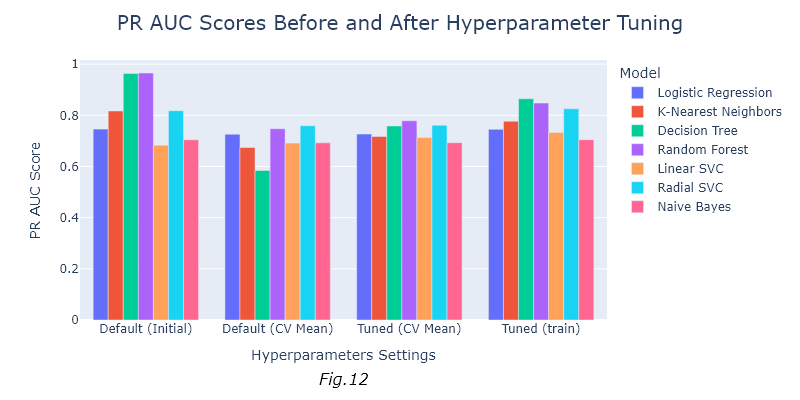

In [50]:
melted_df = models_default_tuned.melt(
    id_vars="Model",
    value_vars=[
        "Initial PR AUC",
        "Default CV Mean",
        "Tuned Best Mean",
        "Tuned (train)",
    ],
    var_name="Type",
    value_name="Mean",
)

melted_df["Type"] = melted_df["Type"].replace(
    {
        "Initial PR AUC": "Default (Initial)",
        "Default CV Mean": "Default (CV Mean)",
        "Tuned Best Mean": "Tuned (CV Mean)",
    }
)

fig12 = px.bar(
    melted_df,
    x="Type",
    y="Mean",
    color="Model",
    barmode="group",
    labels={"Mean": "PR AUC Score", "Type": "Hyperparameters Settings"},
)

fig_update(
    fig12,
    "PR AUC Scores Before and After Hyperparameter Tuning",
    "<i>Fig.12</i>",
    "Hyperparameters Settings",
    "PR AUC Score",
    "Model",
    800,
    400,
)

fig_px_render(fig12, render_mode, "Fig12")

During the *hyperparameter tuning* phase each model was tuned with *GridSearchCV*. All models show performance improvement, compared with results from *cross-validation* with default settings (*Fig.12*), with a small trade-off in stability, as standard deviation of all models has slightly increased.

Subsequent double-check of the tuned models on *train* set shows that the models tend to generalize better than during the initial phase.

Considering the scores of all models after the *hyperparameter tuning*, three models have been selected for final predictions on *test* data and construction of ensemble - **Decision Tree**, **Random Forest** and **Radial SVC**.

### 4.5 Predictions on Test Data
#### 4.5.1 Individual Predictions

In [51]:
top_3_models = ["Decision Tree", "Random Forest", "Radial SVC"]

In [52]:
def tuned_models_predict(models_dict, model_name, X_vars, y_target):
    """
    This function is not designed for re-use, thus remains inside the notebook
    The sole purpose of this function is to avoid repeating code when predicting
    with the top 3 performing models and collecting data necessary for further
    analysis
    """
    y_pred = models_dict[model_name].predict(X_vars)
    y_pred_proba = models_dict[model_name].predict_proba(X_vars)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_target, y_pred_proba)
    pr_auc = average_precision_score(y_target, y_pred_proba)
    pr_data = pd.DataFrame(
        {
            "Recall": recall,
            "Precision": precision,
            "PR AUC": pr_auc,
            "Model": model_name,
        }
    )
    print(f"{model_name} Full Classification Report:")
    print(
        classification_report(
            y_target, y_pred, target_names=["Majority (0)", "Minority (1)"]
        )
    )

    return pr_data

In [53]:
all_pr_data = pd.DataFrame()

for model in top_3_models:
    pr_data = tuned_models_predict(tuned_models_dict, model, X_test, y_test_array)
    all_pr_data = pd.concat([all_pr_data, pr_data], ignore_index=True)

Decision Tree Full Classification Report:
              precision    recall  f1-score   support

Majority (0)       0.82      0.85      0.84       256
Minority (1)       0.71      0.67      0.69       142

    accuracy                           0.79       398
   macro avg       0.77      0.76      0.76       398
weighted avg       0.78      0.79      0.78       398

Random Forest Full Classification Report:
              precision    recall  f1-score   support

Majority (0)       0.80      0.98      0.88       256
Minority (1)       0.94      0.56      0.70       142

    accuracy                           0.83       398
   macro avg       0.87      0.77      0.79       398
weighted avg       0.85      0.83      0.82       398

Radial SVC Full Classification Report:
              precision    recall  f1-score   support

Majority (0)       0.82      0.97      0.89       256
Minority (1)       0.91      0.61      0.73       142

    accuracy                           0.84       398
   ma

The three classification reports show that each model handles the minority class (customers who will buy travel insurance) differently. The *Decision Tree* has lower recall for the minority class (0.67), meaning it misses many of these customers, although its precision (0.71) is decent. The *Random Forest* model has great precision (0.94) for the minority class but struggles with recall (0.56), missing a lot of the minority customers. The *Radial SVC* also has high precision (0.91) but only a moderate recall (0.61), similar to *Random Forest*. While all models perform well with the majority class, none of them fully balance precision and recall for the minority class.

Combining these models into a voting ensemble could help improve overall performance, especially for the minority class. The *Decision Tree's* better recall for the minority class can be balanced by the precision of the *Random Forest* and *Radial SVC* models, making the ensemble better at identifying minority customers. A voting ensemble would allow the models to complement each other, helping reduce the bias towards the majority class that any single model might have. By leveraging the strengths of all three, the ensemble could offer a more reliable classifier with better results for the minority class.

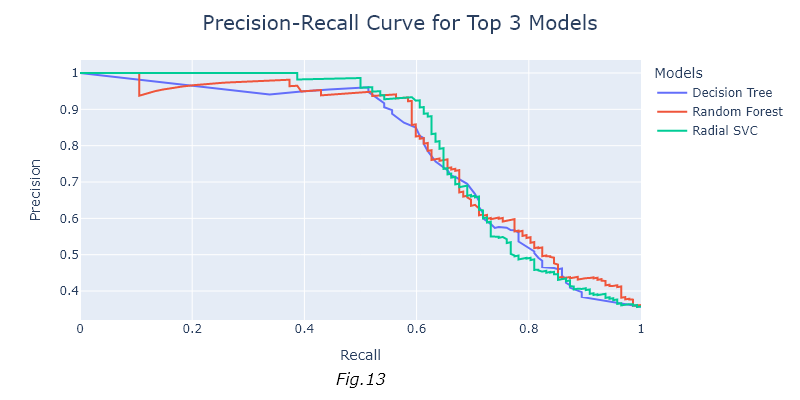

In [54]:
fig13 = px.line(
    all_pr_data, 
    x='Recall', y='Precision', 
    color='Model', 
    line_group='Model', 
    hover_data=['PR AUC'],
)

fig_update(
    fig13,
    "Precision-Recall Curve for Top 3 Models",
    "<i>Fig.13</i>",
    "Recall",
    "Precision",
    "Models",
    800,
    400,
)

fig_px_render(fig13, render_mode, "Fig13")

#### 4.5.2 Voting Ensemble

In [55]:
voting_ensemble = VotingClassifier(estimators=[
        ("Decision Tree", tuned_models_dict["Decision Tree"]),
        ("Random Forest", tuned_models_dict["Random Forest"]),
        ("Radial SVC", tuned_models_dict["Radial SVC"]),
    ],
    voting="soft",
)

voting_ensemble.fit(X_train, y_train_array)

y_pred_ve = voting_ensemble.predict(X_test)
y_pred_proba_ve = voting_ensemble.predict_proba(X_test)[:, 1]
precision_ve, recall_ve, thresholds_ve = precision_recall_curve(
    y_test_array, y_pred_proba_ve
)
pr_auc_ve = average_precision_score(y_test_array, y_pred_proba_ve)
pr_data_ve = pd.DataFrame(
    {
        "Recall": recall_ve,
        "Precision": precision_ve,
        "PR AUC": pr_auc_ve,
        "Model": "Voting Ensemble",
    }
)
all_pr_data = pd.concat([all_pr_data, pr_data_ve], ignore_index=True)

print(f"Voting Ensemble Full Classification Report:")
print(
    classification_report(
        y_test_array, y_pred_ve, target_names=["Majority (0)", "Minority (1)"]
    )
)

Voting Ensemble Full Classification Report:
              precision    recall  f1-score   support

Majority (0)       0.81      0.97      0.88       256
Minority (1)       0.91      0.60      0.72       142

    accuracy                           0.84       398
   macro avg       0.86      0.78      0.80       398
weighted avg       0.85      0.84      0.83       398



In [56]:
cm = confusion_matrix(y_test_array, y_pred_ve)
print("Voting Ensemble Confusion Matrix:")
print(cm)

Voting Ensemble Confusion Matrix:
[[248   8]
 [ 57  85]]


The *Voting Ensemble* effectively combines the strengths of the individual models. It achieves high precision for the minority class (0.91), similar to *Random Forest* and *Radial SVC*, while maintaining a balanced recall (0.60) that improves over *Random Forest* but is slightly lower than the *Decision Tree*. For the majority class, it performs well with high recall (0.97) and precision (0.81), leading to an overall accuracy of 0.84.

Compared to the individual models, the ensemble strikes a better balance between precision and recall for the minority class, improving its ability to identify these customers without increasing false positives significantly. This performance aligns with expectations from the earlier analysis, demonstrating that the ensemble provides a more reliable and balanced classifier across both classes.

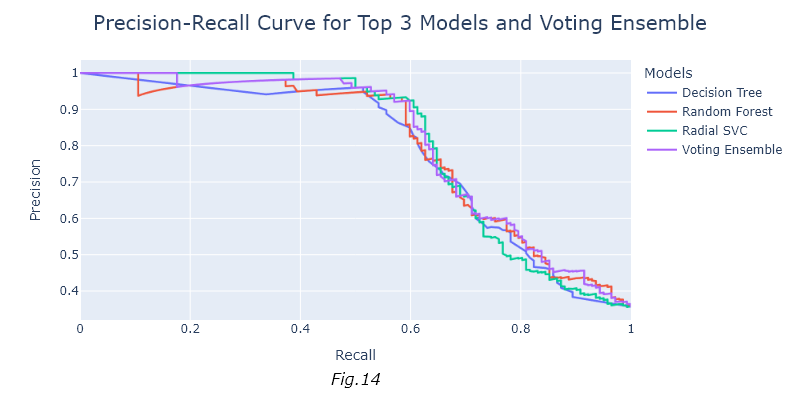

In [60]:
fig14 = px.line(
    all_pr_data, 
    x='Recall', y='Precision', 
    color='Model', 
    line_group='Model', 
    hover_data=['PR AUC'],
)

fig_update(
    fig14,
    "Precision-Recall Curve for Top 3 Models and Voting Ensemble",
    "<i>Fig.14</i>",
    "Recall",
    "Precision",
    "Models",
    800,
    400,
)

fig_px_render(fig14, render_mode, "Fig14")

As shown in *Fig.14*, *Precision-Recall Curve* of *Voting Ensemble* (purple line) stays closely with *Random Forest* and *Radial SVC* at high precision, however at higher recall values provides some compensation of low precision from the three component models.

*Voting Ensemble* achieves high accuracy (84%) and precision (91%), meaning it correctly classifies most instances and avoids false positives effectively. However, its recall is lower (60%), indicating it misses a significant portion of actual positives, with 57 false negatives. This trade-off suggests the model is conservative in predicting positives, favoring precision over recall, which may be suitable in scenarios where false positives are more critical than false negatives.

From a business perspective, the model's high precision implies it is effective at identifying customers likely to buy travel insurance, minimizing marketing efforts on uninterested customers. However, the lower recall indicates it misses nearly 40% of potential buyers, leading to lost opportunities for revenue. To maximize business impact, improving recall (e.g., by adjusting the decision threshold) could help identify more potential buyers, increasing overall sales while balancing marketing efficiency.

# 5. Closing Remarks

**Dataset**<br>
Total 1987 rows were split into training and test sets at a 80/20 ratio. The trainingset (1589 rows) contains 523 duplicated rows and 639 rows that may create potential outcome conflict. Although duplicated and conflicting rows may introduce bias and unnecessary noise, it was decided tokeep the data as it is for model training.

**Features**<br>
Two out of three numerical features were classified as categorical. Six categorical features, including target variable, are binary.

**Customers**<br>
The perfect customer of the Travel & Tours Company may be described as a representative of private sector (or self-employed) of 33-35 years of age with more than 5 persons in the family and annual income of more than 1.3 million INR. The perfect customer also likes to travel abroad and therefore has a frequent flyer status.

**PR AUC vs Accuracy**<br>
PR AUC was chosen over Accuracy as a key metric for model performance evaluation as it focuses on precision and recall, which are relevant for evaluating the performance of the positive class.

**Models**<br>
Seven models were trained, cross-validated and tuned. Three most promising model were selected based on the PR AUC metric of model performance. All three models were used for predicting of outcomes based on test data.

**Hyperparameter Tuning**<br>
Some of the calculations are quite computationally costly compared with marginal improvement of model performance. 

**Voting Ensemble**<br>
Three most promising models were orchestrated into a Voting Ensemble, which was trained and used for the final prediction.

**Space for Further Analysis/Improvement**<br>
Simulation and analysis of "what-if" scenario (virtual A/B experiment) for exploring potential gains with marketing campaigns targeted at domestic travellers.

Threshold tuning for final models for improvement of recall values.
